In [1]:
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
import numpy  as np
# sys.path.append('./pyperch')
# from pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import torch
import random
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, make_scorer, f1_score, confusion_matrix, log_loss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from pipelines import KMeans_pipeline, TSNE_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import helpers
import importlib
import pipelines
import pipeline_helpers
import seaborn as sns
from scipy.stats import kurtosis
from notebook_helper import reload_notebook_cell, generate_seed
from sklearn.model_selection import KFold


## Get Data

In [2]:

from generate_data import get_and_preprocess_sdas_data, get_and_preprocess_raisin_data, y_label_encode, CATEGORY_COLUMNS_UCML
from sklearn.preprocessing import  LabelEncoder
reload_notebook_cell()

X_train_sdas, X_test_sdas, y_train_sdas, y_test_sdas = get_and_preprocess_sdas_data()
X_train_raisin, X_test_raisin, y_train_raisin, y_test_raisin = get_and_preprocess_raisin_data()

# Initialize and fit LabelEncoder
y_train_encoded_sdas, y_test_encoded_sdas, label_encoder_sdas = y_label_encode(y_train_sdas,y_test_sdas)
y_train_encode_raisin, y_test_encode_raisin, label_encoder_raisin = y_label_encode(y_train_raisin, y_test_raisin)

# get data to correct type for NN
y_train_encoded_sdas = y_train_encoded_sdas.astype(np.int64)
y_train_encode_raisin = y_train_encode_raisin.astype(np.int64)

cv = KFold(n_splits=4, shuffle=False)

c:\Users\WarrenKushner\Documents\ML\A3\generate_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X["Marital Status"]  != 1) & (X["Marital Status"] != 2) & (X["Marital Status"] != 4)]["Marital Status"] = -1


Removed columns: ["encoding__Mother's qualification_18", "encoding__Mother's qualification_44", "encoding__Father's qualification_18", "encoding__Father's occupation_161"]
Number of features after removal: 200


## Generate DR Pipelines with best parameters

In [47]:
reload_notebook_cell()
best_pca_raisin = {"n_components": 3, "random_state":42 }
best_rp_raisin = {"n_components": 5, "random_state":42 }
best_ica_raisin = {"n_components": 2,  'n_components':2, 'whiten': 'unit-variance',  "random_state":42 }

pipeline_PCA_Raisin = pipelines.PCANoStandard_pipeline(X_train_raisin, y_train_encode_raisin,  **best_pca_raisin)
pipeline_RP_Raisin = pipelines.GaussianRPNoStandard_pipeline(X_train_raisin, y_train_encode_raisin,  **best_rp_raisin)
pipeline_ICA_Raisin = pipelines.ICA_pipeline(X_train_raisin, y_train_encode_raisin, **best_ica_raisin)







In [49]:
# import Kfold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
reload_notebook_cell()
best_net_inputs_raisin =   {
    "module__hidden_units": 25,
    "module__hidden_layers": 1,
    "module__activation": torch.nn.ReLU(),
    "optimizer__lr": 0.0025,
    "max_epochs": 150, # 88 for raisin
    "module__input_dim": 3,
    "module__output_dim": 2,

}
best_net_inputs_raisin["module__input_dim"] = 3
net_pipeline_pca = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_PCA_Raisin,**best_net_inputs_raisin)
# adjust for RP
best_net_inputs_raisin["module__input_dim"] = 5
net_pipeline_rp = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_RP_Raisin,**best_net_inputs_raisin)

# adjust for ICA
best_net_inputs_raisin["module__input_dim"] = 2
net_pipeline_ica = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_ICA_Raisin,**best_net_inputs_raisin)

# adjust for original
best_net_inputs_raisin["module__input_dim"] = 7
net_pipeline_orginal = pipelines.NN_pipeline(X_train_raisin,[],  None,**best_net_inputs_raisin)


cpu
cpu
cpu
cpu


## Loss Curves

In [50]:
reload_notebook_cell()
# Function to get loss curves and find the best epoch
# Function to get average training history per epoch
def run_and_get_avg_history(net_pipeline, X, y):
    X = X  # Ensure X is a NumPy array
    y = np.array(y)  # Ensure y is a NumPy array
    
    train_losses = []
    val_losses = []
    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        history = net_pipeline.fit(X_train, y_train)['classifier']
        
        train_loss_per_epoch = [ his['train_loss']for his in history.history ] 
        val_loss_per_epoch = [ his['valid_loss']for his in history.history ] 
        
        train_losses.append(train_loss_per_epoch)
        val_losses.append(val_loss_per_epoch)
    
    avg_train_loss = np.mean(np.array(train_losses), axis=0)
    avg_val_loss = np.mean(np.array(val_losses), axis=0)
    
    return avg_train_loss, avg_val_loss


# Run the models and capture loss curves
# Get average histories for each model
avg_train_loss_pca, avg_val_loss_pca = run_and_get_avg_history(net_pipeline_pca, X_train_raisin, y_train_encode_raisin)
avg_train_loss_rp, avg_val_loss_rp = run_and_get_avg_history(net_pipeline_rp, X_train_raisin, y_train_encode_raisin)
avg_train_loss_ica, avg_val_loss_ica = run_and_get_avg_history(net_pipeline_ica, X_train_raisin, y_train_encode_raisin)
avg_train_loss_orginal, avg_val_loss_orginal = run_and_get_avg_history(net_pipeline_orginal, X_train_raisin, y_train_encode_raisin)

# Find the best epoch
best_epoch_pca = np.argmin(avg_val_loss_pca) + 1
best_epoch_rp = np.argmin(avg_val_loss_rp) + 1
best_epoch_ica = np.argmin(avg_val_loss_ica) + 1
best_epoch_orginal = np.argmin(avg_val_loss_orginal) + 1



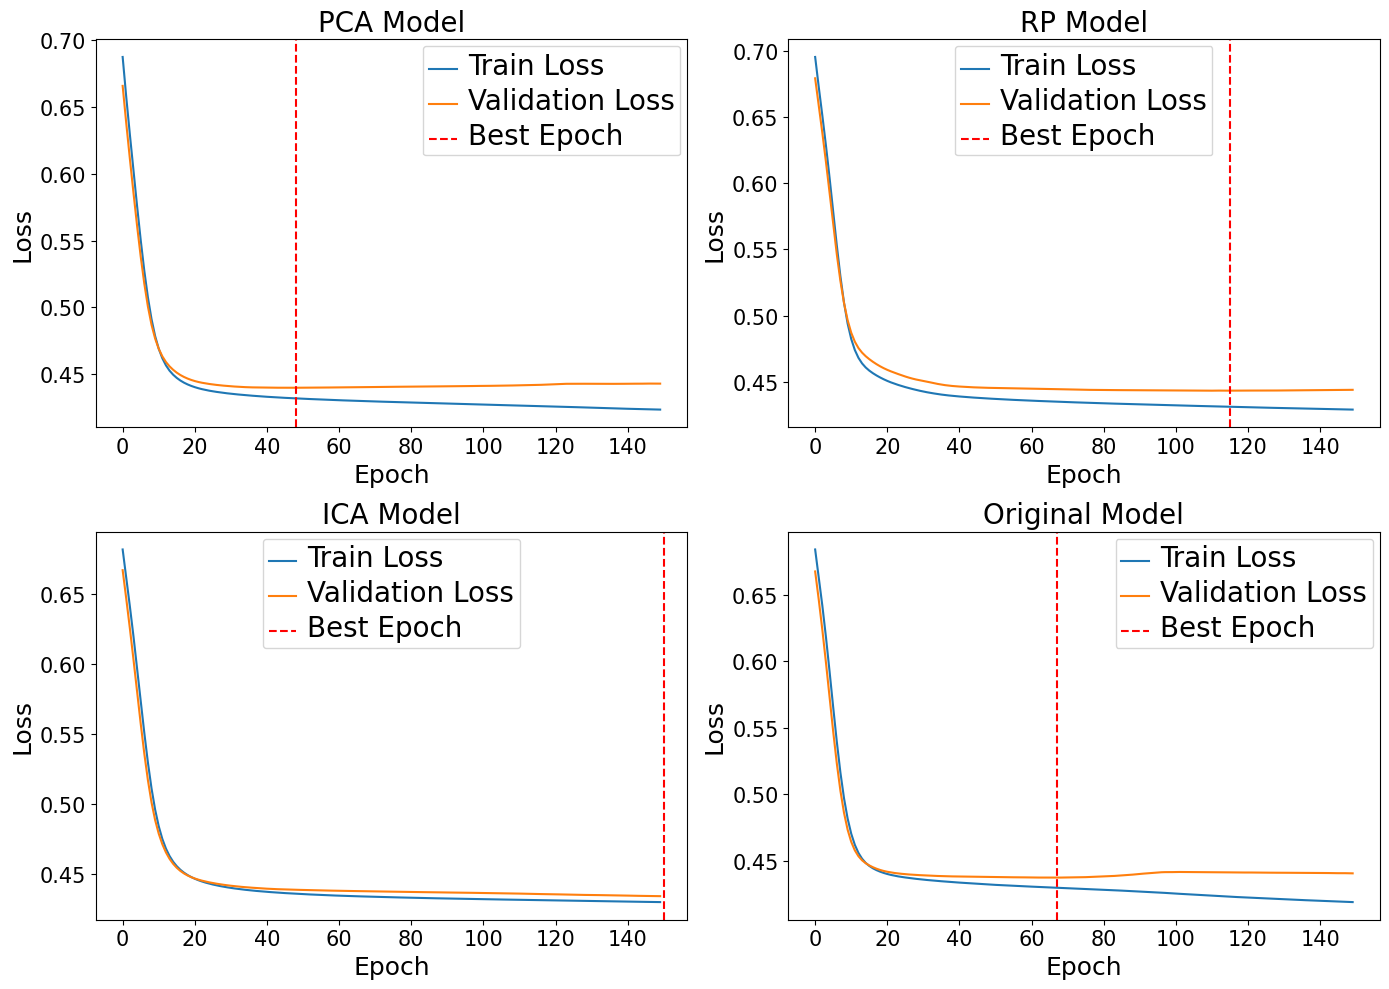

{'PCA': 48, 'RP': 115, 'ICA': 150, 'Original': 67}


In [51]:
# Plot the loss curves in subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# PCA subplot
axs[0, 0].plot(avg_train_loss_pca, label='Train Loss')
axs[0, 0].plot(avg_val_loss_pca, label='Validation Loss')
axs[0, 0].axvline(x=best_epoch_pca, color='r', linestyle='--', label='Best Epoch')
axs[0, 0].set_title('PCA Model')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# RP subplot
axs[0, 1].plot(avg_train_loss_rp, label='Train Loss')
axs[0, 1].plot(avg_val_loss_rp, label='Validation Loss')
axs[0, 1].axvline(x=best_epoch_rp, color='r', linestyle='--', label='Best Epoch')
axs[0, 1].set_title('RP Model')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# ICA subplot
axs[1, 0].plot(avg_train_loss_ica, label='Train Loss')
axs[1, 0].plot(avg_val_loss_ica, label='Validation Loss')
axs[1, 0].axvline(x=best_epoch_ica, color='r', linestyle='--', label='Best Epoch')
axs[1, 0].set_title('ICA Model')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Original subplot
axs[1, 1].plot(avg_train_loss_orginal, label='Train Loss')
axs[1, 1].plot(avg_val_loss_orginal, label='Validation Loss')
axs[1, 1].axvline(x=best_epoch_orginal, color='r', linestyle='--', label='Best Epoch')
axs[1, 1].set_title('Original Model')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
helpers.increase_font_size_subplots_included(plt)
plt.tight_layout()
plt.show()

best_epochs = {
    'PCA': best_epoch_pca,
    'RP': best_epoch_rp,
    'ICA': best_epoch_ica,
    'Original': best_epoch_orginal
}


print(best_epochs)

### reparameterize NN pipeliens with best epoch

In [52]:
best_net_inputs_raisin["max_epochs"] = best_epoch_pca
best_net_inputs_raisin["module__input_dim"] = 3
net_pipeline_pca = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_PCA_Raisin,**best_net_inputs_raisin)
# adjust for RP
best_net_inputs_raisin["module__input_dim"] = 5
best_net_inputs_raisin["max_epochs"] = best_epoch_rp
net_pipeline_rp = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_RP_Raisin,**best_net_inputs_raisin)

# adjust for ICA
best_net_inputs_raisin["module__input_dim"] = 2
best_net_inputs_raisin["max_epochs"] = best_epoch_ica
net_pipeline_ica = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_ICA_Raisin,**best_net_inputs_raisin)

# adjust for original
best_net_inputs_raisin["module__input_dim"] = 7
best_net_inputs_raisin["max_epochs"] = best_epoch_orginal
net_pipeline_orginal = pipelines.NN_pipeline(X_train_raisin,[],  None,**best_net_inputs_raisin)

cpu
cpu
cpu
cpu


In [53]:
reload_notebook_cell()
# perform cross validation
scores_pca = cross_validate( 
               net_pipeline_pca, 
               X_train_raisin, 
               y_train_encode_raisin, 
               cv=cv, 
               return_train_score=True, 
               scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score), 'log_loss': make_scorer(log_loss)}, n_jobs=1)

scores_rp = cross_validate( 
                net_pipeline_rp, 
                X_train_raisin, 
                y_train_encode_raisin, 
                cv=cv, 
                return_train_score=True, 
                scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score), 'log_loss': make_scorer(log_loss)},  n_jobs=1)

scores_ica = cross_validate(
                net_pipeline_ica, 
                X_train_raisin, 
                y_train_encode_raisin, 
                cv=cv, 
                return_train_score=True, 
                scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score), 'log_loss': make_scorer(log_loss)},  n_jobs=1)
scores_orginal = cross_validate(
                net_pipeline_orginal, 
                X_train_raisin, 
                y_train_encode_raisin, 
                cv=cv, 
                return_train_score=True, 
                scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score), 'log_loss': make_scorer(log_loss)})

In [54]:
import pandas as pd
# Example cross-validation results dictionaries for other methods


# Convert to DataFrames
df_scores_rp = pd.DataFrame(scores_rp)
df_scores_ica = pd.DataFrame(scores_ica)
df_scores_orginal = pd.DataFrame(scores_orginal)
df_scores_pca = pd.DataFrame(scores_pca)
# Rename columns
df_scores_rp.rename(columns={'test_accuracy': 'validation_accuracy', 'test_log_loss': 'validation_log_loss'}, inplace=True)
df_scores_ica.rename(columns={'test_accuracy': 'validation_accuracy', 'test_log_loss': 'validation_log_loss'}, inplace=True)
df_scores_orginal.rename(columns={'test_accuracy': 'validation_accuracy', 'test_log_loss': 'validation_log_loss'}, inplace=True)
df_scores_pca.rename(columns={'test_accuracy': 'validation_accuracy', 'test_log_loss': 'validation_log_loss'}, inplace=True)

# Drop F1 columns
df_scores_rp.drop(columns=['test_f1', 'train_f1'], inplace=True)
df_scores_ica.drop(columns=['test_f1', 'train_f1'], inplace=True)
df_scores_orginal.drop(columns=['test_f1', 'train_f1'], inplace=True)
df_scores_pca.drop(columns=['test_f1', 'train_f1'], inplace=True)

# Add method names
df_scores_pca['method'] = 'PCA'
df_scores_rp['method'] = 'RP'
df_scores_ica['method'] = 'ICA'
df_scores_orginal['method'] = 'Original'

# Combine all DataFrames
df_all_scores = pd.concat([df_scores_pca, df_scores_rp, df_scores_ica, df_scores_orginal], ignore_index=True)
df_avg_scores = df_all_scores.groupby('method').mean().reset_index()
df_avg_scores

,method,fit_time,score_time,validation_accuracy,train_accuracy,validation_log_loss,train_log_loss
0,ICA,3.759364,0.012702,0.876389,0.884259,4.455396,4.171719
1,Original,1.668860,0.018801,0.872222,0.883333,4.605578,4.205093
2,PCA,1.317733,0.014465,0.879167,0.878704,4.355275,4.371962
3,RP,2.676362,0.017266,0.863889,0.878241,4.905942,4.388649


## See How each model performs on the test set

In [56]:
reload_notebook_cell()
best_net_inputs_raisin["max_epochs"] = best_epoch_pca
best_net_inputs_raisin["module__input_dim"] = 3
net_pipeline_pca = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_PCA_Raisin,**best_net_inputs_raisin)
# adjust for RP
best_net_inputs_raisin["module__input_dim"] = 5
best_net_inputs_raisin["max_epochs"] = best_epoch_rp
net_pipeline_rp = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_RP_Raisin,**best_net_inputs_raisin)

# adjust for ICA
best_net_inputs_raisin["module__input_dim"] = 2
best_net_inputs_raisin["max_epochs"] = best_epoch_ica
net_pipeline_ica = pipelines.NN_pipeline(X_train_raisin,[],  pipeline_ICA_Raisin,**best_net_inputs_raisin)

# adjust for original
best_net_inputs_raisin["module__input_dim"] = 7
best_net_inputs_raisin["max_epochs"] = best_epoch_orginal
net_pipeline_orginal = pipelines.NN_pipeline(X_train_raisin,[],  None,**best_net_inputs_raisin)

cpu
cpu
cpu
cpu


In [57]:
reload_notebook_cell()
net_pipeline_pca.fit(X_train_raisin, y_train_encode_raisin)
net_pipeline_rp.fit(X_train_raisin, y_train_encode_raisin)
net_pipeline_ica.fit(X_train_raisin, y_train_encode_raisin)
net_pipeline_orginal.fit(X_train_raisin, y_train_encode_raisin)

NN(steps=[('preprocessor',
           ColumnTransformer(remainder='passthrough',
                             transformers=[('num', StandardScaler(),
                                            ['MajorAxisLength',
                                             'MinorAxisLength', 'Perimeter',
                                             'Eccentricity', 'Area', 'Extent',
                                             'ConvexArea'])])),
          ('classifier',
           <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CustomBackpropModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=7, out_features=25, bias=True)
      (1): Linear(in_features=25, out_features=25, bias=True)
      (2): Linear(in_features=25, out_features=2, bias=True)
    )
  ),
))])

In [61]:
reload_notebook_cell()
## evaluate accuracy and log loss of the models on test 
y_pred_pca = net_pipeline_pca.predict(X_test_raisin)
y_pred_rp = net_pipeline_rp.predict(X_test_raisin)
y_pred_ica = net_pipeline_ica.predict(X_test_raisin)
y_pred_orginal = net_pipeline_orginal.predict(X_test_raisin)

accuracy_pca = accuracy_score(y_test_encode_raisin, y_pred_pca)
accuracy_rp = accuracy_score(y_test_encode_raisin, y_pred_rp)
accuracy_ica = accuracy_score(y_test_encode_raisin, y_pred_ica)
accuracy_orginal = accuracy_score(y_test_encode_raisin, y_pred_orginal)

log_loss_pca = log_loss(y_test_encode_raisin, net_pipeline_pca.predict_proba(X_test_raisin))
log_loss_rp = log_loss(y_test_encode_raisin, net_pipeline_rp.predict_proba(X_test_raisin))
log_loss_ica = log_loss(y_test_encode_raisin, net_pipeline_ica.predict_proba(X_test_raisin))
log_loss_orginal = log_loss(y_test_encode_raisin, net_pipeline_orginal.predict_proba(X_test_raisin))

print(f'Accuracy PCA: {accuracy_pca:.4f}, Log Loss PCA: {log_loss_pca:.4f}')
print(f'Accuracy RP: {accuracy_rp:.4f}, Log Loss RP: {log_loss_rp:.4f}')
print(f'Accuracy ICA: {accuracy_ica:.4f}, Log Loss ICA: {log_loss_ica:.4f}')
print(f'Accuracy Original: {accuracy_orginal:.4f}, Log Loss Original: {log_loss_orginal:.4f}')
# add to df
df_avg_scores['test_accuracy'] = [accuracy_ica, accuracy_orginal, accuracy_pca, accuracy_rp]
df_avg_scores['test_log_loss'] = [log_loss_ica, log_loss_orginal, log_loss_pca, log_loss_rp]

df_avg_scores

Accuracy PCA: 0.8500, Log Loss PCA: 0.4530
Accuracy RP: 0.8444, Log Loss RP: 0.4541
Accuracy ICA: 0.8667, Log Loss ICA: 0.4470
Accuracy Original: 0.8611, Log Loss Original: 0.4502


,method,fit_time,score_time,validation_accuracy,train_accuracy,validation_log_loss,train_log_loss,test_accuracy,test_log_loss
0,ICA,3.759364,0.012702,0.876389,0.884259,4.455396,4.171719,0.866667,0.446987
1,Original,1.668860,0.018801,0.872222,0.883333,4.605578,4.205093,0.861111,0.450194
2,PCA,1.317733,0.014465,0.879167,0.878704,4.355275,4.371962,0.850000,0.452996
3,RP,2.676362,0.017266,0.863889,0.878241,4.905942,4.388649,0.844444,0.454114
